In [10]:
from binance.client import Client
# client = Client(api_key, api_secret)
import time
import dateparser
import pytz
from datetime import datetime
import json
import pandas as pd

from backtesting import Strategy
from backtesting.lib import crossover

In [5]:
def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds
    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/
    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)


def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds
    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str
    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/
    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Biannce Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str
    :return: list of OHLCV values
    """
    # create the Binance client, no need for api key
    client = Client("", "")

    # init our list
    output_data = []

    # setup the max limit
    limit = 500

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data


def get_ohlc(symbol, start, end="1 hour ago", interval=Client.KLINE_INTERVAL_1DAY):
    start_str = start + " UTC"
    end_str = end + " UTC"
    klinesa = get_historical_klines(symbol, interval,start_str, end_str)
    start_ts = date_to_milliseconds(start_str)
    cnames = ['open_time', 'Open', 'High', 'Low', 'Close', 'volume', 'close_time', 
              'volume', 'n_trades',' taker_buybase_volume', 'taker_buyquote_volume', 'ignore']
    odf = pd.DataFrame.from_dict(klinesa)
    odf.columns = cnames
    outdf = odf.copy()[['Open','High', 'Low', 'Close']]
    outdf.index = pd.to_datetime(odf['open_time'], unit='ms')
    cols = outdf.columns
    outdf[cols] = outdf[cols].apply(pd.to_numeric, errors='coerce')
    return outdf

In [ ]:
# symfile = pd.read_csv("/home/ubuntu/binance_data/binance_tickers.txt", header=None, sep="\t", names=['symbol'])
# syms = [i for i in set(symfile.symbol.values)]
# outfile = "/home/ubuntu/binance_data/klines_usdsymbols.txt"

# for symbol in syms:
#     klinesa = get_historical_klines(symbol, Client.KLINE_INTERVAL_1MINUTE, "5 minutes ago UTC")
#     dfout = pd.DataFrame.from_dict(klinesa)
#     dfout['symbol'] = symbol
#     dfout['time'] = str(datetime.now())
#     dfout.to_csv(outfile, mode='a', sep="\t", header=False, index=False)

In [104]:
btcusdt_5min = get_ohlc("BTCUSDT", "4 months ago", interval=Client.KLINE_INTERVAL_15MINUTE)
print(len(btcusdt_5min))

In [55]:
def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)


from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):
            
            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)
        
        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()

In [ ]:
%%time
backtest = Backtest(btcusdt_5min, System, commission=.009)
backtest.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10))

In [102]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [109]:
df['atr'] = atr(df, n=100)
df.head()

from backtesting.test import GOOG

GOOG['atr'] = atr(GOOG, n=100)
GOOG.head()

,Open,High,Low,Close,Volume,atr
2004-08-19,100.00,104.06,95.96,100.34,22351900,8.100000
2004-08-20,101.01,109.08,100.50,108.31,11428600,8.106400
2004-08-23,110.75,113.48,109.05,109.40,9137200,8.077036
2004-08-24,111.24,111.60,103.57,104.87,7631300,8.076566
2004-08-25,104.96,108.00,103.88,106.00,4598900,8.037000


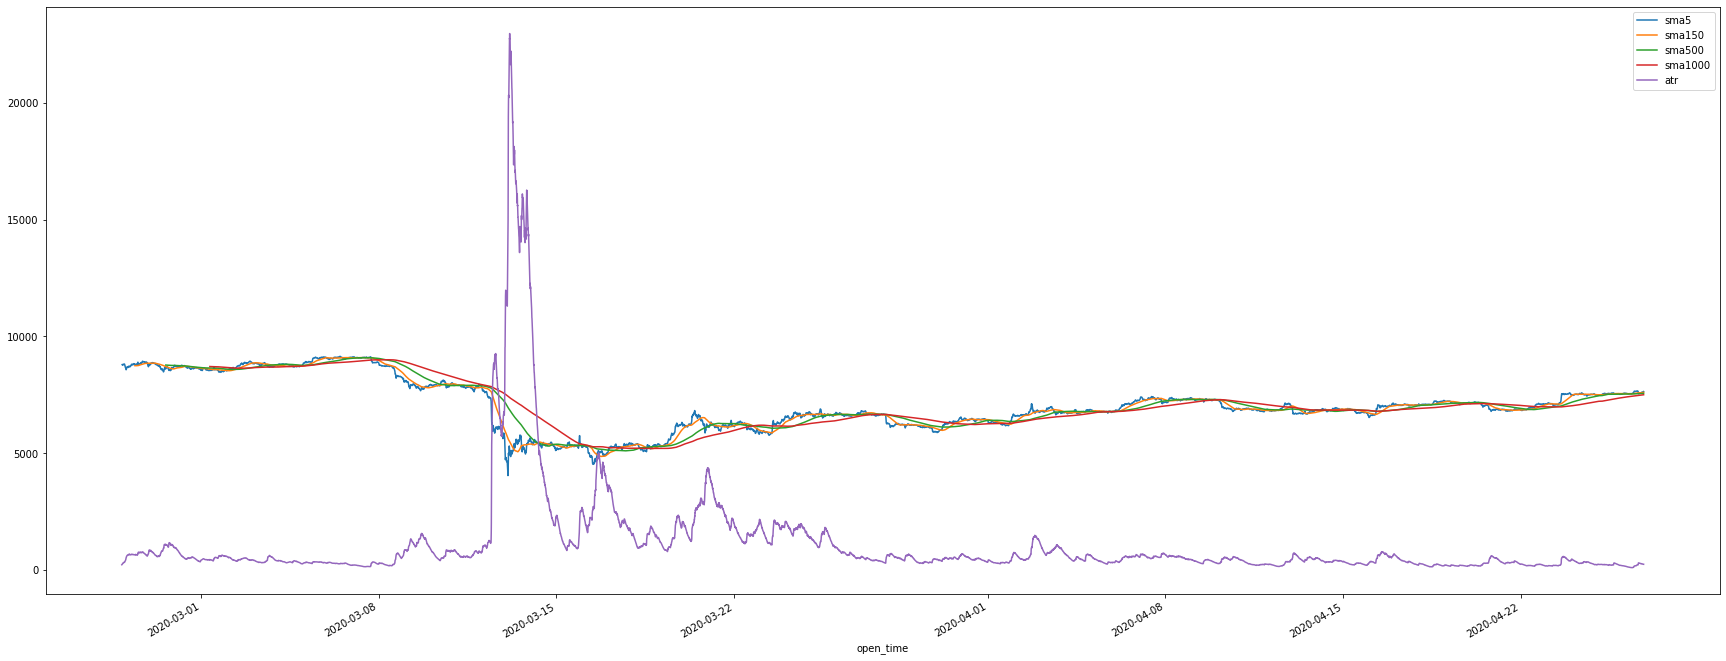

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [30, 12]
df = btcusdt_5min.copy()
df['sma5'] = SMA(df.copy().Close.values, 5).values
df['sma150'] = SMA(df.copy().Close.values, 150).values
df['sma500'] = SMA(df.copy().Close.values, 500).values
df['sma1000'] = SMA(df.copy().Close.values, 1000).values
df['atr'] = atr(df, n=100)
df.head()
df2 = df.drop(columns=['Close', 'Open','High', 'Low'])
df2.plot()

In [70]:
df.head()

,Open,High,Low,Close,sma
open_time,,,,,
2020-02-26 21:15:00,8824.59,8835.00,8820.00,8821.52,NaN
2020-02-26 21:20:00,8820.13,8821.29,8792.36,8800.37,NaN
2020-02-26 21:25:00,8800.37,8811.16,8793.90,8802.18,NaN
2020-02-26 21:30:00,8802.55,8802.89,8765.00,8779.52,NaN
2020-02-26 21:35:00,8779.00,8780.47,8757.09,8773.34,NaN
